# Optimizing variables over transition rate


In this notebook we are going to implement the method presented in Mouaffac etal. (J. Chem. Theory Comput. 2023, 19, 17, 5701–5711) on a simple 2D example.

In [130]:
import numpy as np
import folie as fl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.optimize

In [13]:
# Define model to simulate and type of simulator to use
dt = 1e-3

potential=fl.functions.MullerBrown()
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.asarray([0.5]) * np.eye(2, 2))
model_simu = fl.models.overdamped.Overdamped(force=potential, diffusion=diff_function)


(36, 36) (36, 36)


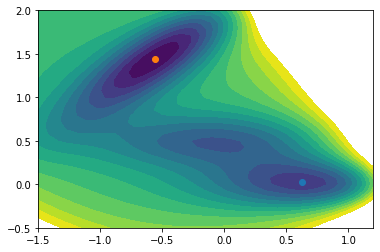

In [157]:
x = np.linspace(-1.5, 1.2, 36)
y = np.linspace(-0.5, 2.0, 36)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)

# Plot potential surface
pot = potential.potential_plot(X, Y)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))

# Also find the two minima of the potential

product = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[0.5, 0]).x.reshape(1,-1)  # minima one
reactant = scipy.optimize.minimize(lambda x:potential.potential(x.reshape(1,-1)), x0=[-0.5, 1.5]).x.reshape(1,-1)  # minima two
ax.scatter(*product[0])
ax.scatter(*reactant[0])

Lets run some simulations of the model. We launch simulations from the transition state to obtain a full sampling of the transition.

In [34]:
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)

# initialize positions
ntraj = 30
q0 = np.empty(shape=[ntraj, 2])
for i in range(ntraj):
    q0[i,:] = [-0.90,0.500]

# Calculate Trajectory
time_steps = 20000
data = simulator.run(time_steps, q0, save_every=1)


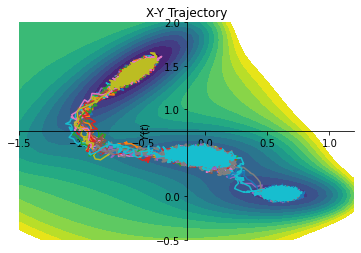

In [35]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
axs.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
for n, trj in enumerate(data):
    axs.plot(trj["x"][:, 0], trj["x"][:, 1])
    axs.spines["left"].set_position("center")
    axs.spines["right"].set_color("none")
    axs.spines["bottom"].set_position("center")
    axs.spines["top"].set_color("none")
    axs.xaxis.set_ticks_position("bottom")
    axs.yaxis.set_ticks_position("left")
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

Next step is to define a projection of the trajectories onto a 1d coordinate. We are using a simple neural network to define the projection.

In [60]:
# Transform data into torch tensor
est=fl.KramersMoyalEstimator(model_simu)
for trj in data:
    est.preprocess_traj(trj)
xt_torch=torch.Tensor(np.concatenate([(trj["xt"]) for trj in data], axis=0))
x_torch=torch.Tensor(np.concatenate([(trj["x"]) for trj in data], axis=0))

In [63]:
print(xt_torch)
print(x_torch)

tensor([[-0.9380,  0.5371],
        [-0.9350,  0.5369],
        [-0.9411,  0.5762],
        ...,
        [ 0.6170,  0.0158],
        [ 0.6138,  0.0319],
        [ 0.6480,  0.0303]])
tensor([[-0.9188,  0.5182],
        [-0.9380,  0.5371],
        [-0.9350,  0.5369],
        ...,
        [ 0.5612,  0.0276],
        [ 0.6170,  0.0158],
        [ 0.6138,  0.0319]])


In [189]:
#initialization of the neural network
input_size = 2
output_size = 1
projection = nn.Sequential(
    nn.Linear(input_size, 8), nn.ELU(),
#     nn.Linear(8, 8), nn.ELU(),
    nn.Linear(8, 1), nn.Sigmoid()
)

print(projection(x_torch))

# Show the initial cv
new_cv = projection(torch.Tensor(np.column_stack([X.ravel(),Y.ravel()]))).detach().numpy().reshape(X.shape)
print(new_cv)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

tensor([[0.5543],
        [0.5563],
        [0.5562],
        ...,
        [0.4332],
        [0.4286],
        [0.4300]], grad_fn=<SigmoidBackward0>)


Let's now create the model

In [190]:
est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories()
data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
print(data_proj[0]["x"].shape)
est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(0.01,0.99,150))
plt.plot(np.linspace(0,1,150), pmf)

(599970, 1)


KramersMoyalEstimator-133868357777920:[{'model': Overdamped-133868357218416:[{'diffusion': BSplinesFunction-133868357212128:[{'bc_type': None,
                                                                                                   'coefficients': array([ 0.00000000e+00, -3.48419210e-15,  2.62579737e-01,  8.84471737e-03,
                                                                                                          4.61436405e-03,  6.83212678e-03, -2.56308714e-03,  7.34617264e-02,
                                                                                                          0.00000000e+00,  0.00000000e+00]),
                                                                                                   'domain': <folie.domains.MeshedDomain object at 0x79c0a7e0da20>,
                                                                                                   'k': None,
                                                                               

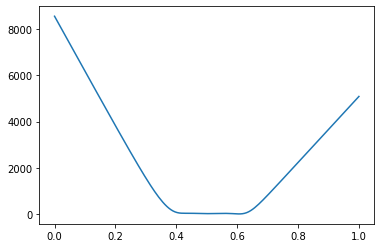

In [192]:
proj_product=projection(torch.Tensor(product)).detach().numpy()[0,0]
proj_reactant=projection(torch.Tensor(reactant)).detach().numpy()[0,0]
print(proj_reactant,proj_product)
mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[0.01,0.99], x_start=proj_reactant)
print(mfpt)

0.6042306 0.42908752
103876207182.28708


In [193]:
def optimize_rate(params, params_shape):
    # Restore params shapes
    arrs=np.split(init_params, np.cumsum([np.prod(s) for s in params_shape]))
    reshaped_params= [a.reshape(s) for a,s in zip(arrs,params_shape)]
    for p,new_p in zip(projection.parameters(),reshaped_params):
        p.data = torch.Tensor(new_p)
    data_proj = fl.Trajectories()
    data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
    est.fit(data_proj)
    proj_product=projection(torch.Tensor(product)).detach().numpy()[0,0]
    proj_reactant=projection(torch.Tensor(reactant)).detach().numpy()[0,0]
    mfpt = fl.analysis.mfpt_1d(model_fit,x_end=proj_product, x_range=[0.01,0.99], x_start=proj_reactant)
    return 1/mfpt

We can now run the optimisation

In [194]:
params_shape = [p.detach().numpy().shape for p in projection.parameters()]
init_params=np.concatenate([p.detach().numpy().ravel() for p in projection.parameters()])
print(init_params, params_shape)
print([p.detach().numpy().ravel() for p in projection.parameters()])

[ 0.18574478 -0.12352449 -0.59268045 -0.27714553  0.4782773  -0.34622717
 -0.4803059   0.33345795  0.09625717 -0.5744607  -0.4567411  -0.28478843
 -0.06058972  0.5726419   0.42190292 -0.22406411 -0.3092799   0.09817046
  0.2971222  -0.07904278 -0.37564576 -0.08161037 -0.26670593  0.2055775
 -0.3419276  -0.34454918 -0.31639087 -0.14202277  0.01424525  0.34786728
  0.29646686 -0.35213673  0.06057644] [(8, 2), (8,), (1, 8), (1,)]
[array([ 0.18574478, -0.12352449, -0.59268045, -0.27714553,  0.4782773 ,
       -0.34622717, -0.4803059 ,  0.33345795,  0.09625717, -0.5744607 ,
       -0.4567411 , -0.28478843, -0.06058972,  0.5726419 ,  0.42190292,
       -0.22406411], dtype=float32), array([-0.3092799 ,  0.09817046,  0.2971222 , -0.07904278, -0.37564576,
       -0.08161037, -0.26670593,  0.2055775 ], dtype=float32), array([-0.3419276 , -0.34454918, -0.31639087, -0.14202277,  0.01424525,
        0.34786728,  0.29646686, -0.35213673], dtype=float32), array([0.06057644], dtype=float32)]


In [183]:
init_params[:]=0.0
arrs=np.split(init_params, np.cumsum([np.prod(s) for s in params_shape]))
reshaped_params= [a.reshape(s) for a,s in zip(arrs,params_shape)]
for p,new_p in zip(projection.parameters(),reshaped_params):
    p.data = torch.Tensor(new_p)
print([p.detach().numpy().ravel() for p in projection.parameters()])

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([0.], dtype=float32)]


In [195]:
from scipy.optimize import minimize
    
res=minimize(optimize_rate, init_params, args=(params_shape,), method='Nelder-Mead', tol=1e-3)
print(res.x)

[ 0.18574478 -0.12352449 -0.59268045 -0.27714553  0.4782773  -0.34622717
 -0.48030591  0.33345795  0.09625717 -0.57446069 -0.45674109 -0.28478843
 -0.06058972  0.57264191  0.42190292 -0.22406411 -0.30927989  0.09817046
  0.29712221 -0.07904278 -0.37564576 -0.08161037 -0.26670593  0.20557749
 -0.34192759 -0.34454918 -0.31639087 -0.14202277  0.01424525  0.34786728
  0.29646686 -0.35213673  0.06057644]


In [198]:
print("Final rate",res.fun)

Final rate 9.626843597063097e-12


[[0.51411426 0.5109335  0.5075851  ... 0.36209804 0.3566996  0.35125813]
 [0.518009   0.5149166  0.51165956 ... 0.3669113  0.36148643 0.35601774]
 [0.52193046 0.5189243  0.5157567  ... 0.3718073  0.3663565  0.36086068]
 ...
 [0.6445588  0.64366406 0.6426876  ... 0.5556002  0.5503298  0.54498726]
 [0.64793575 0.6470901  0.64617515 ... 0.5615718  0.55631673 0.5510089 ]
 [0.65127295 0.65047526 0.64965177 ... 0.5675226  0.56228435 0.55699533]]


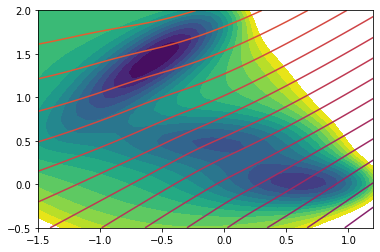

In [201]:
# Plot the new cv
new_cv = projection(torch.Tensor(np.column_stack([X.ravel(),Y.ravel()]))).detach().numpy().reshape(X.shape)
print(new_cv)
fig = plt.figure()
ax = plt.axes()
ax.contourf(X, Y, pot-np.min(pot), levels=np.linspace(0,50,15))
ax.contour(X, Y, new_cv, cmap="inferno", levels=np.linspace(0,1,50))

(599970, 1)


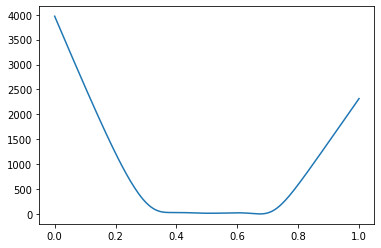

In [200]:
est=fl.KramersMoyalEstimator(model_fit)
data_proj = fl.Trajectories()
data_proj.append({"x": projection(x_torch).detach().numpy(), "xt": projection(xt_torch).detach().numpy(), "dt":dt})
print(data_proj[0]["x"].shape)
est.fit(data_proj)
pmf=fl.analysis.free_energy_profile_1d(model_fit, np.linspace(0.2,0.8,150))
plt.plot(np.linspace(0,1,150), pmf)

For comparison, a computation of the committor can be done